<b>Task content</b> Find an (unpopular) set for regression. Prepare an xgboost model and additional 2
models you will choice. Select hyperparameters using Optuna library.Perform cross-validation.
### Steel Industry Energy Consumption dataset - Regression
The data set is available on https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption. And it contains data on electricty consumption in company which produces several types of coils, steel plates, and iron plates. Each entry in the dataset is a measurement taken every 15 minutes on each day in 2018.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector
import xgboost
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
import optuna
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
#load the dataset
df = pd.read_csv('Steel_industry_data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

### Variables in the dataset
The dataset has 10 columns and each of columns contains 35040 entries.
1. Date - time series - time data taken every 15 minutes,
2. Usage_kWh - numerical data (min 0 - max 157.18) in kWh,
3. Lagging_Current_Reactive.Power_kVarh - numerical data (min 0 max 96.91) in KVarh,
4. Leading_Current_Reactive_Power_kVarh - numerical data (min 0 max 27.76) in KVarh,
5. CO2(tCO2) - CO2 Continuous ppm - numerical data (min 0 max 0.07),
6. Lagging_Current_Power_Factor - numerical data (min 0 max 100),
7. Leading_Current_Power_Factor - numerical data (min 0 max 100),
6. NSM - Number of Seconds from midnight numerical data in Seconds (min 0 max 85500),
7. WeekStatus - categorical data (Weekend or a Weekday),
8. Day_of_week - categorical data,
9. Load_Type - categorical data.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Usage_kWh,35040.0,27.386892,33.444380,0.0,3.20,4.57,51.2375,157.18
Lagging_Current_Reactive.Power_kVarh,35040.0,13.035384,16.306000,0.0,2.30,5.00,22.6400,96.91
Leading_Current_Reactive_Power_kVarh,35040.0,3.870949,7.424463,0.0,0.00,0.00,2.0900,27.76
CO2(tCO2),35040.0,0.011524,0.016151,0.0,0.00,0.00,0.0200,0.07
Lagging_Current_Power_Factor,35040.0,80.578056,18.921322,0.0,63.32,87.96,99.0225,100.00
Leading_Current_Power_Factor,35040.0,84.367870,30.456535,0.0,99.70,100.00,100.0000,100.00
NSM,35040.0,42750.000000,24940.534317,0.0,21375.00,42750.00,64125.0000,85500.00


In [5]:
#convert the data in  "date" column to datetime format
df['date']= pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35040 entries, 2018-01-01 00:15:00 to 2018-12-31 00:00:00
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Usage_kWh                             35040 non-null  float64
 1   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 2   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   CO2(tCO2)                             35040 non-null  float64
 4   Lagging_Current_Power_Factor          35040 non-null  float64
 5   Leading_Current_Power_Factor          35040 non-null  float64
 6   NSM                                   35040 non-null  int64  
 7   WeekStatus                            35040 non-null  object 
 8   Day_of_week                           35040 non-null  object 
 9   Load_Type                             35040 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage

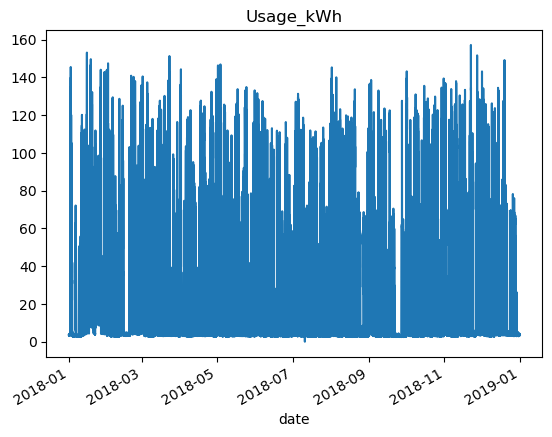

In [7]:
#plot the "Usage_kWh" column
df['Usage_kWh'].plot()
plt.title('Usage_kWh')
plt.show()

Observations in the collection are made every fifteen minutes throughout the 2018 year, so the above chart for "Usage_kWh" variable without using any grouping (e.g., daily, monthly) is not very readable. My next charts will be grouped by day and month.

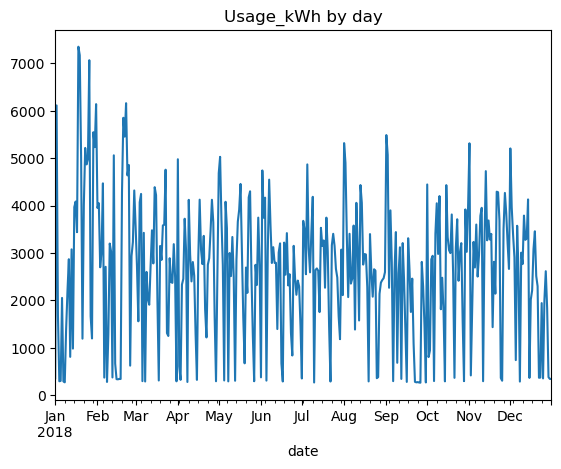

In [8]:
#resample the "Usage_kWh" column by day and plot it
df['Usage_kWh'].resample('D').sum().plot()
plt.title('Usage_kWh by day')
plt.show()

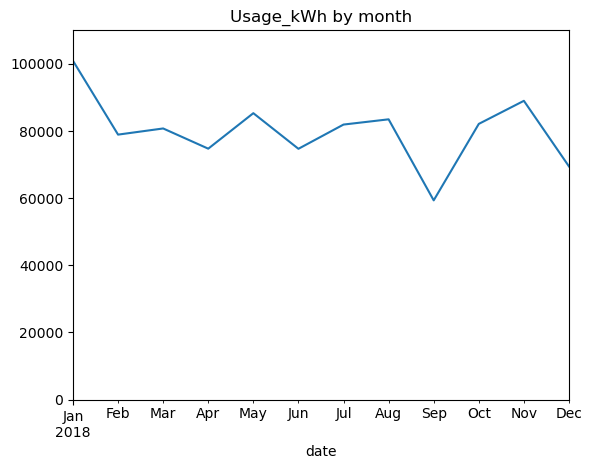

In [9]:
#resample the "Usage_kWh" column by month and plot it
df['Usage_kWh'].resample('M').sum().plot()
plt.title('Usage_kWh by month')
plt.ylim(0, 110000)
plt.show()

From the above chart we can infer that the highest  electricity consumption was in January and the lowest in September.

In [10]:
#add the "hour" column to check the consumption by hour
df['hour'] = df.index.hour
df['month'] = df.index.month

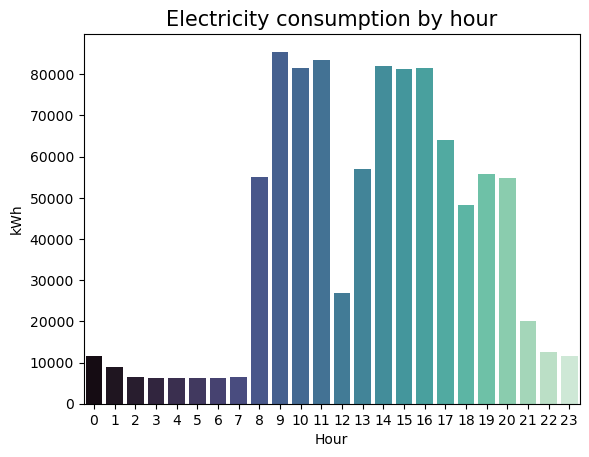

In [11]:
#create a new data set to visualize hourly consumption
usage_by_hour = df.copy()
usage_by_hour = usage_by_hour.groupby(['hour'])['Usage_kWh'].sum()
usage_by_hour = usage_by_hour.reset_index()
sns.barplot(x='hour',y='Usage_kWh',data=usage_by_hour, palette ='mako')
plt.title('Electricity consumption by hour', fontsize=15)
plt.xlabel("Hour", size=10)
plt.ylabel('kWh')
plt.show()

From the chart above, we can conclude that the factory runs from 8AM-8PM. The highest consumption in the morning is between 9 and 11AM,and in the afternoon between 2 and 4PM.

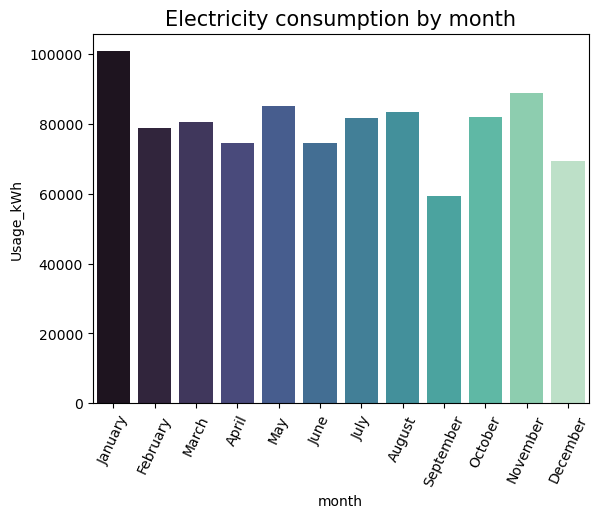

In [12]:
#define a function for apply the month name in the data_frame
def month_name(month):
    return month_names.get(month)

month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July',
              8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

#create a new data set to visualize monthly consumption
usage_by_month = df.copy()
usage_by_month = usage_by_month.groupby(['month'])['Usage_kWh'].sum()
usage_by_month = usage_by_month.reset_index()
usage_by_month['month'] = usage_by_month['month'].apply(month_name)
sns.barplot(x='month',y='Usage_kWh',data=usage_by_month, palette ='mako')
plt.title('Electricity consumption by month', fontsize=15)
plt.xlabel("month", size=10)
plt.xticks(rotation=65)
plt.ylabel('Usage_kWh')
plt.show()

Looking at the chart above, we can confirm what we have already checked before - the highest electricity consumption was in January and the lowest was in September.

In [13]:
#check unique values in the "Day_of_week" column
df['Day_of_week'].unique()

array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'], dtype=object)

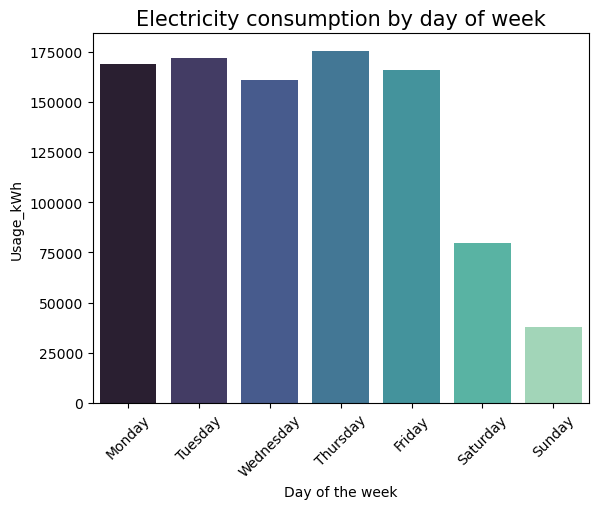

In [14]:
#create the order of the days for the chart
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
#create a new data set to visualize consumption by day of week
usage_Day_of_week = df.groupby(['Day_of_week'])['Usage_kWh'].sum()
usage_Day_of_week  = usage_Day_of_week .reset_index()
sns.barplot(x='Day_of_week',y='Usage_kWh',data=usage_Day_of_week , order=order, palette ='mako')
plt.title('Electricity consumption by day of week', fontsize=15)
plt.xlabel("Day of the week", size=10)
plt.xticks(rotation=45)
plt.ylabel("Usage_kWh")
plt.show()

Looking at the chart above we can conclude that the factory runs from Monday to Friday. Power consumption is similar from day to day, but highest on Thursdays. The lowest was on Sundays, and on working days the lowest was on Wednesdays.

In [15]:
#check unique values in the "Load_Type" column
df['Load_Type'].unique()

array(['Light_Load', 'Medium_Load', 'Maximum_Load'], dtype=object)

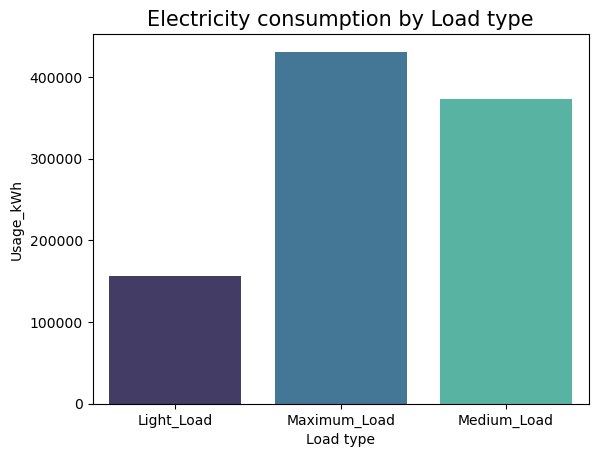

In [16]:
#create a new data set to visualize consumption Load type
usage_load_type = df.groupby(['Load_Type'])['Usage_kWh'].sum()
usage_load_type  = usage_load_type .reset_index()
sns.barplot(x='Load_Type',y='Usage_kWh',data=usage_load_type, palette ='mako')
plt.title('Electricity consumption by Load type', fontsize=15)
plt.xlabel("Load type", size=10)
plt.ylabel("Usage_kWh")
plt.show()

The highest current consumption is for a load of the "Maximum" type, medium for "Medium" and lowest for "Light."

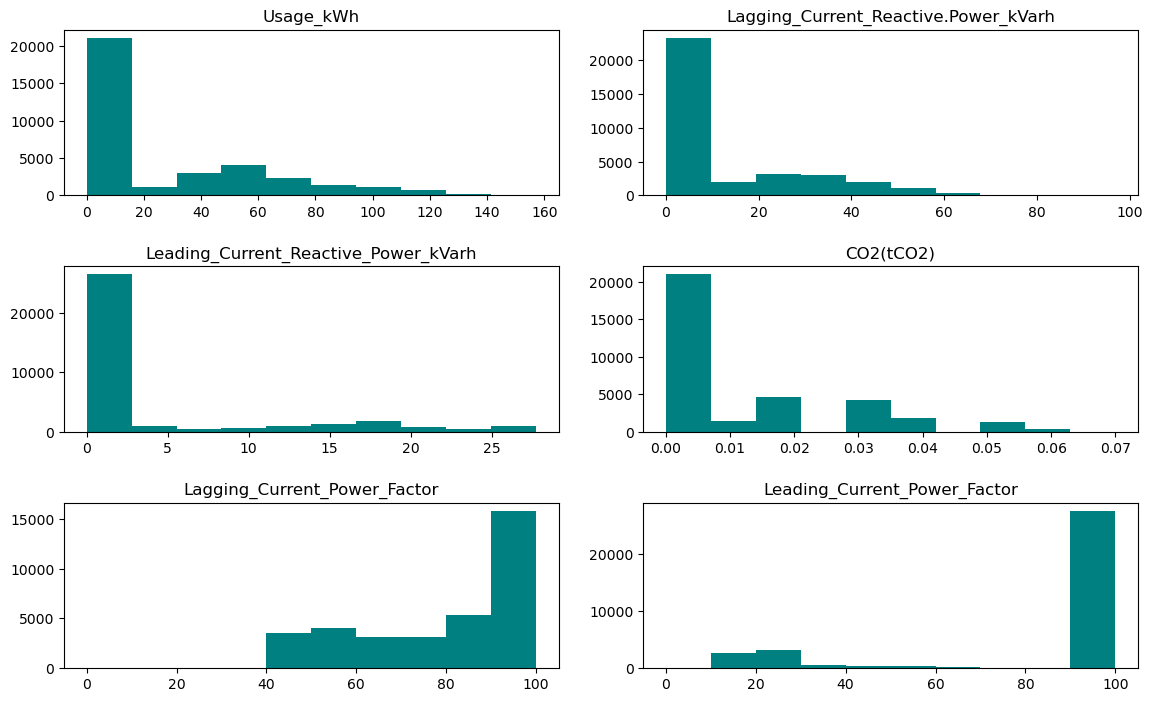

In [17]:
#plot histogram for each column with numerical data
plt.figure(figsize=(12,12))
ax0 = plt.subplot2grid((5, 2), (0, 0), colspan=1)
ax1 = plt.subplot2grid((5, 2), (0, 1), colspan=1)
ax2 = plt.subplot2grid((5, 2), (1, 0), colspan=1)
ax3 = plt.subplot2grid((5, 2), (1, 1), colspan=1)
ax4 = plt.subplot2grid((5, 2), (2, 0), colspan=1)
ax5 = plt.subplot2grid((5, 2), (2, 1), colspan=1)

plt.tight_layout(pad=3)

feature_cols = list(df.drop(['NSM','Day_of_week', 'WeekStatus','Load_Type'], axis=1).columns)
axes = [ax0, ax1, ax2, ax3, ax4, ax5]

for ax, feature in zip(axes, feature_cols):
    ax.hist(df[feature],  color='#008080')
    ax.set_title(feature)

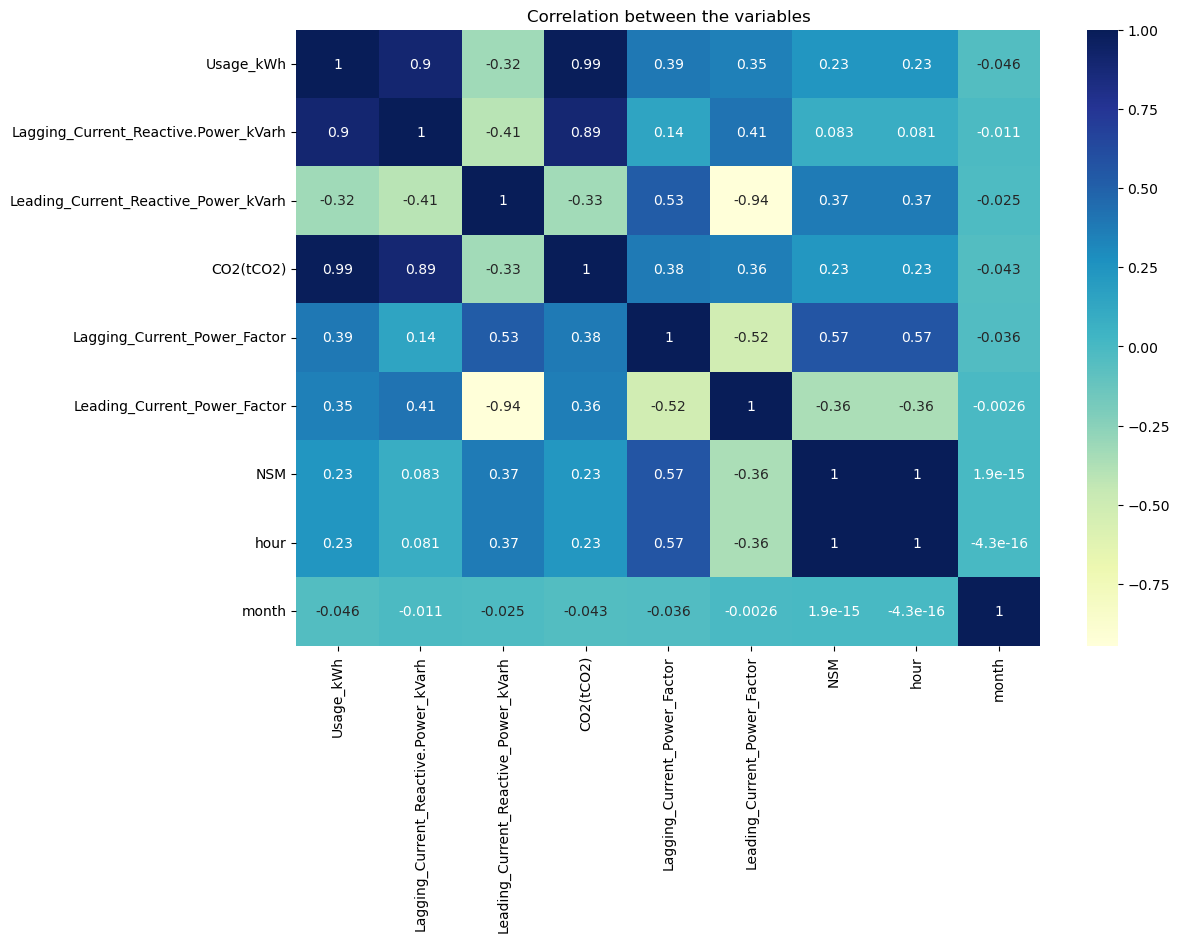

In [18]:
plt.figure(figsize=(12,8))
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.title('Correlation between the variables')
plt.show()

In [19]:
df = df.drop('CO2(tCO2)',axis=1)

I decided to removed 'CO2(tCO2)' feature from the dataset due to its strong correlation with the target variable and the suspicion that the values for the feature were calculated on the valuse from the target column(Usage_kWh).

### XGBoost Regressor model
Now I am going to create the XGBoost Regressor model. I have to do label encoding for the categorical data, for columns "Day of week" and "Load Type" I decided to use order labeling.

In [20]:
#label encoding for the "Day of week" feature with order labeling
days_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
days_labels = pd.factorize(days_names)[0]
df['Day_of_week'] = df['Day_of_week'].map(dict(zip(days_names, days_labels)))

In [21]:
#label encoding for the "Day of week" feature with order labeling
load_types_names = ["Light_Load", "Medium_Load", "Maximum_Load"]
load_types_labels = pd.factorize(load_types_names)[0]
df['Load_Type'] = df['Load_Type'].map(dict(zip(load_types_names, load_types_labels)))

In [22]:
# label encoding for categorical data
label_encoder = preprocessing.LabelEncoder()
# encode labels in column 'class'
df['WeekStatus']= label_encoder.fit_transform(df['WeekStatus'])

In [23]:
#define the target and the feauters
target = 'Usage_kWh'
X = df.drop(target,axis=1).copy()#features
y = df[target].copy() #target

In [24]:
#create a XGBoost regressor model
model = XGBRegressor(random_state=42)

In [25]:
#feature selection by using SelectFromModel
featureSelection = SelectFromModel(model)
featureSelection.fit(X, y)

SelectFromModel(estimator=XGBRegressor(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bynode=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, feature_types=None,
                                       gamma=None, gpu_id=None,
                                       grow_policy=None, importance_type=None,
                                       interaction_constraints=None,
                                       learning_rate=None, max_bin=None,
                                       max_cat_threshold=None,
                                       max_cat_to_onehot=None,
                                       max_delta_step=None, max_depth=None,
                                       max_leaves=None, min_child_weight=None,
                                       missing=nan, monotone_constraints=None,
                                       n_estimators=100, n_jobs=None,
                                       num_parallel_tree=None, predictor=None,
                                       random_state=42, ...))

In [26]:
#check the selected features names
X.columns[featureSelection.get_support()]

Index(['Lagging_Current_Reactive.Power_kVarh', 'Load_Type'], dtype='object')

In [27]:
selected_columns = X.columns[featureSelection.get_support()]

In [28]:
#split the dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X[selected_columns], y, test_size=0.33, random_state=42)

In [29]:
#use the optuna library to optimize model parameters
#define a objective function 
def objective_xgboost(trial):
    #define hyperparameters to search
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000)    
    }
    #create and train XGBoost model
    model = xgboost.XGBRegressor(**param, random_state=42)
    model.fit(X_train, y_train)
    #predict on test data
    y_pred = model.predict(X_test)
    return mean_absolute_percentage_error(y_test, y_pred)

In [30]:
#create a study object for the optimization process 
study_xgboost = optuna.create_study(direction='minimize', study_name='regression')
study_xgboost.optimize(objective_xgboost, n_trials=100)#optimization process 

[I 2023-05-14 12:02:26,508] A new study created in memory with name: regression
[I 2023-05-14 12:02:27,446] Trial 0 finished with value: 0.3739600515256578 and parameters: {'max_depth': 4, 'learning_rate': 0.7584331556403328, 'n_estimators': 415}. Best is trial 0 with value: 0.3739600515256578.
[I 2023-05-14 12:02:30,476] Trial 1 finished with value: 0.36941830959311067 and parameters: {'max_depth': 6, 'learning_rate': 0.16200590309747268, 'n_estimators': 983}. Best is trial 1 with value: 0.36941830959311067.
[I 2023-05-14 12:02:32,020] Trial 2 finished with value: 0.37891073048396956 and parameters: {'max_depth': 5, 'learning_rate': 0.7806254372488961, 'n_estimators': 563}. Best is trial 1 with value: 0.36941830959311067.
[I 2023-05-14 12:02:33,792] Trial 3 finished with value: 0.37506924579043377 and parameters: {'max_depth': 4, 'learning_rate': 0.62546469730624, 'n_estimators': 812}. Best is trial 1 with value: 0.36941830959311067.
[I 2023-05-14 12:02:34,744] Trial 4 finished with v

[I 2023-05-14 12:03:09,141] Trial 35 finished with value: 0.3657791382957563 and parameters: {'max_depth': 8, 'learning_rate': 0.16242419480506196, 'n_estimators': 353}. Best is trial 14 with value: 0.3108759641042271.
[I 2023-05-14 12:03:12,867] Trial 36 finished with value: 0.36651385771415385 and parameters: {'max_depth': 9, 'learning_rate': 0.07224599107625773, 'n_estimators': 660}. Best is trial 14 with value: 0.3108759641042271.
[I 2023-05-14 12:03:14,677] Trial 37 finished with value: 0.34296751385793667 and parameters: {'max_depth': 10, 'learning_rate': 0.013096893711303981, 'n_estimators': 258}. Best is trial 14 with value: 0.3108759641042271.
[I 2023-05-14 12:03:15,046] Trial 38 finished with value: 0.3603749187703861 and parameters: {'max_depth': 6, 'learning_rate': 0.13076843969595953, 'n_estimators': 91}. Best is trial 14 with value: 0.3108759641042271.
[I 2023-05-14 12:03:16,009] Trial 39 finished with value: 0.3663465633563224 and parameters: {'max_depth': 9, 'learning_r

[I 2023-05-14 12:03:50,992] Trial 71 finished with value: 0.33397886364934637 and parameters: {'max_depth': 9, 'learning_rate': 0.03412587274405119, 'n_estimators': 87}. Best is trial 61 with value: 0.3049720779137972.
[I 2023-05-14 12:03:51,582] Trial 72 finished with value: 0.3349914388952863 and parameters: {'max_depth': 9, 'learning_rate': 0.03410127041232377, 'n_estimators': 88}. Best is trial 61 with value: 0.3049720779137972.
[I 2023-05-14 12:03:52,275] Trial 73 finished with value: 0.36273524175309635 and parameters: {'max_depth': 9, 'learning_rate': 0.11063856861152185, 'n_estimators': 114}. Best is trial 61 with value: 0.3049720779137972.
[I 2023-05-14 12:03:53,589] Trial 74 finished with value: 0.3527631934881337 and parameters: {'max_depth': 9, 'learning_rate': 0.02754498163881714, 'n_estimators': 155}. Best is trial 61 with value: 0.3049720779137972.
[I 2023-05-14 12:03:54,156] Trial 75 finished with value: 0.361691787432824 and parameters: {'max_depth': 8, 'learning_rate'

In [32]:
print('Best parameters', study_xgboost.best_params)#check the best hyperparameters

Best parameters {'max_depth': 8, 'learning_rate': 0.0301320991826263, 'n_estimators': 63}


In [33]:
#create the model again using the best hyperparameters
model = xgboost.XGBRegressor(**study_xgboost.best_params, random_state=42)
model.fit(X_train, y_train)#train the model
y_fitted = model.predict(X_train)#make a prediction on train set
y_pred = model.predict(X_test)# make a prediction on test set

In [34]:
#Evaluate the model
r2 = r2_score(y_test, y_pred)
cv_scores = cross_val_score(model, X_test, y_test, cv=5)
print(f"Mean Absolute Error XGBoost on train: {mean_absolute_error(y_train, y_fitted)}")
print(f"Mean Absolute Error XGBoost on test: {mean_absolute_error(y_test, y_pred)}")
print("R-squared Score XGBoost: ", r2)
print("Cross-validation scores XGBoost: ", cv_scores)

Mean Absolute Error XGBoost on train: 6.388670374764192
Mean Absolute Error XGBoost on test: 6.632317888236137
R-squared Score XGBoost:  0.8624367189698914
Cross-validation scores XGBoost:  [0.8672084  0.86024764 0.84731411 0.858453   0.86695045]


### Elastic net regression
Now I am going to do the same using Elastic Net model.XGBoost regressor doesn't require scaled data for optimal performance, but for an Elastic Net model, it is necessary to scale the dataset before using it for predicting electricity usage. So I will use the Standard Scaler to scale the features for the Elastic Net model.

In [35]:
# use standard scaler to create a new data frame with scaled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(target,axis=1).copy())

In [36]:
#split the dataset into train and test data
X_train_enet, X_test_enet, y_train_enet, y_test_enet = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [37]:
#define the objective function
def objective(trial):
    #define hyperparameters to search
    alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)

    #create the Elastic Net model
    enet = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    enet.fit(X_train_enet, y_train_enet)

    #predict on test data
    y_pred_enet = enet.predict(X_test_enet)
    return mean_absolute_percentage_error(y_test_enet, y_pred_enet)

In [38]:
#create a study object and run optimization process for the Elastic Net model
study_enet = optuna.create_study(direction='minimize')
study_enet.optimize(objective, n_trials=100)

[I 2023-05-14 12:06:08,650] A new study created in memory with name: no-name-a83f9983-00e8-495a-a200-7b6e65566a80
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:08,668] Trial 0 finished with value: 0.7915119502042178 and parameters: {'alpha': 0.035605279819351035, 'l1_ratio': 0.08313993052813062}. Best is trial 0 with value: 0.7915119502042178.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_lo

/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:09,158] Trial 8 finished with value: 0.8038304297584654 and parameters: {'alpha': 0.1331154654736942, 'l1_ratio': 0.05705460591973022}. Best is trial 0 with value: 0.7915119502042178.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
/home/sylwia/anaconda3/envs/projects/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+06, tolerance: 2.631e+03
  model = cd_fast.enet_coordinate_descent(
[I 2023-0

/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:09,589] Trial 27 finished with value: 0.7977653626720753 and parameters: {'alpha': 0.27064346178662035, 'l1_ratio': 0.44974172764966663}. Best is trial 24 with value: 0.775558693452159.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:09,735] Trial 37 finished with value: 0.7852520858340213 and parameters: {'alpha': 0.0681568871774545, 'l1_ratio': 0.7180551365858486}. Best is trial 24 with value: 0.775558693452159.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/re

/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:09,886] Trial 47 finished with value: 0.7099835139568449 and parameters: {'alpha': 0.6703098785149263, 'l1_ratio': 0.9065180209144029}. Best is trial 47 with value: 0.7099835139568449.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[I 2023-05-14 12:06:10,026] Trial 57 finished with value: 0.6697662677775915 and parameters: {'alpha': 0.9656941980092925, 'l1_ratio': 0.9956619114245596}. Best is trial 57 with value: 0.6697662677775915.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:10,045] Trial 58 finished with value: 0.7406108807977793 and parameters: {'alpha': 0.3716603635038372, 'l1_ratio': 0.9871557468289196}. Best is trial 57 with 

[I 2023-05-14 12:06:10,189] Trial 67 finished with value: 0.7463297118355557 and parameters: {'alpha': 0.34869486512358566, 'l1_ratio': 0.9970068386429695}. Best is trial 64 with value: 0.6679768654218001.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:10,205] Trial 68 finished with value: 0.744582334462732 and parameters: {'alpha': 0.5110960333753275, 'l1_ratio': 0.8033488932917942}. Best is trial 64 with 

[I 2023-05-14 12:06:10,368] Trial 77 finished with value: 0.7676046194493483 and parameters: {'alpha': 0.16772481348402707, 'l1_ratio': 0.8895920276198129}. Best is trial 64 with value: 0.6679768654218001.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:10,389] Trial 78 finished with value: 0.7599879954872159 and parameters: {'alpha': 0.23281442821338705, 'l1_ratio': 0.9595477414456118}. Best is trial 64 wit

[I 2023-05-14 12:06:10,514] Trial 87 finished with value: 0.7298434537459573 and parameters: {'alpha': 0.5772159804921025, 'l1_ratio': 0.8514152763942517}. Best is trial 64 with value: 0.6679768654218001.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:10,532] Trial 88 finished with value: 0.7294804184252905 and parameters: {'alpha': 0.44033301404868774, 'l1_ratio': 0.8977903100241712}. Best is trial 64 with

[I 2023-05-14 12:06:10,679] Trial 97 finished with value: 0.6672306258998687 and parameters: {'alpha': 0.9899127024131704, 'l1_ratio': 0.9769487974380342}. Best is trial 90 with value: 0.6668632001788524.
/tmp/ipykernel_10195/2181429620.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
/tmp/ipykernel_10195/2181429620.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0, 1)
[I 2023-05-14 12:06:10,702] Trial 98 finished with value: 0.7787435223453286 and parameters: {'alpha': 0.14782305542406662, 'l1_ratio': 0.975475058233005}. Best is trial 90 with 

In [39]:
print('Best parameters', study_enet.best_params)#check the best hyperparameters

Best parameters {'alpha': 0.9962193184676448, 'l1_ratio': 0.9751847472660188}


In [40]:
#create the Elastic net model with the best hyperparameters
enet = ElasticNet(**study_enet.best_params)

In [41]:
enet.fit(X_train_enet, y_train_enet)#fit
y_pred_enet = enet.predict(X_test_enet)#make a prediction on test data
y_fitted_enet = enet.predict(X_train_enet)#make a prediction on train data

In [42]:
#Evaluate the model
r2_enet = r2_score(y_test_enet, y_pred_enet)
cv_scores_enet = cross_val_score(enet, X_test_enet, y_test_enet, cv=5)
print(f"Mean Absolute Error ElasticNet on train: {mean_absolute_error(y_train_enet, y_fitted_enet)}")
print(f"Mean Absolute Error ElasticNet on test: {mean_absolute_error(y_test_enet, y_pred_enet)}")
print("R-squared Score ElasticNet: ", r2_enet)
print("Cross-validation scores ElasticNet: ", cv_scores_enet)

Mean Absolute Error ElasticNet on train: 6.643447446531335
Mean Absolute Error ElasticNet on test: 6.781694761535334
R-squared Score ElasticNet:  0.9063965492225663
Cross-validation scores ElasticNet:  [0.90999518 0.90559148 0.90143397 0.90578723 0.90911186]


### KNN regressor
Now I am going to do the same using KNN model. I am also going to use scaled features for this model and the same features as I used for Xgboos model.

In [43]:
#created scaled features based on selected columns for XGboost
X_knn = scaler.fit_transform(X[selected_columns])

In [44]:
# split scaled knn data into train and test sets
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.33, random_state=42)

In [45]:
def objective_knn(trial):
    #Define hyperparameters to search
    n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
    weights = trial.suggest_categorical("weights", ['uniform', 'distance'])
    metric = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])
        
    #create and fit the KNN model
    knn = model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, metric=metric)
    knn.fit(X_train_knn, y_train_knn)
    y_pred_knn = knn.predict(X_test_knn)#predict
    return mean_absolute_percentage_error(y_test_knn, y_pred_knn)

In [46]:
study_knn = optuna.create_study(direction='minimize', study_name='regression')
study_knn.optimize(objective_knn, n_trials=100)

[I 2023-05-14 12:06:33,350] A new study created in memory with name: regression
[I 2023-05-14 12:06:33,442] Trial 0 finished with value: 0.37912216452268643 and parameters: {'n_neighbors': 4, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.37912216452268643.
[I 2023-05-14 12:06:33,538] Trial 1 finished with value: 0.3873393148803088 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.37912216452268643.
[I 2023-05-14 12:06:33,621] Trial 2 finished with value: 0.36011815058834934 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 2 with value: 0.36011815058834934.
[I 2023-05-14 12:06:33,691] Trial 3 finished with value: 0.38684033254266637 and parameters: {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 2 with value: 0.36011815058834934.
[I 2023-05-14 12:06:33,782] Trial 4 finished with value: 0.35246743400419056 and paramet

[I 2023-05-14 12:06:36,804] Trial 37 finished with value: 0.36497533254822384 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:36,904] Trial 38 finished with value: 0.3687164559490687 and parameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:37,000] Trial 39 finished with value: 0.35872947022891927 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:37,092] Trial 40 finished with value: 0.3912142033840862 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'euclidean'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:37,186] Trial 41 finished with value: 0.34674360875559274 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'euclidean'}. 

[I 2023-05-14 12:06:40,125] Trial 74 finished with value: 0.350208273860876 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:40,235] Trial 75 finished with value: 0.3603033678968984 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'manhattan'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:40,328] Trial 76 finished with value: 0.34376030257677576 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'euclidean'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:40,419] Trial 77 finished with value: 0.34674360875559274 and parameters: {'n_neighbors': 12, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 18 with value: 0.34376030257677576.
[I 2023-05-14 12:06:40,509] Trial 78 finished with value: 0.350208273860876 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean'}. Best 

In [47]:
print('Best parameters', study_knn.best_params)#check the best hyperparameters

Best parameters {'n_neighbors': 13, 'weights': 'uniform', 'metric': 'manhattan'}


In [48]:
knn_best = KNeighborsRegressor(**study_knn.best_params)

In [49]:
knn_best.fit(X_train_knn, y_train_knn)#fit
y_pred_knn = knn_best.predict(X_test_knn)#make a prediction on test data
y_fitted_knn = knn_best.predict(X_train_knn)#make a prediction on train data

In [50]:
r2_knn = r2_score(y_test_knn, y_pred_knn)
cv_scores_knn = cross_val_score(knn_best, X_test_knn, y_test_knn, cv=5)

print(f"Mean Absolute Error KNN on train: {mean_absolute_error(y_train_knn, y_fitted_knn)}")
print(f"Mean Absolute Error KNN on test: {mean_absolute_error(y_test_knn, y_pred_knn)}")
print("R-squared Score KNN: ", r2_knn)
print("Cross-validation scores KNN: ", cv_scores_knn)

Mean Absolute Error KNN on train: 5.8017639291191
Mean Absolute Error KNN on test: 6.283117100816859
R-squared Score KNN:  0.8894750425502848
Cross-validation scores KNN:  [0.89738983 0.88952776 0.88493974 0.88830636 0.8937417 ]


### Compare R2 score for the models

In [51]:
print("R-squared Score XGboost: ", r2)
print("R-squared Score Elastic Net: ", r2_enet)
print("R-squared Score KNN: ", r2_knn)

R-squared Score XGboost:  0.8624367189698914
R-squared Score Elastic Net:  0.9063965492225663
R-squared Score KNN:  0.8894750425502848


### Compare mean cross-validation score for the models

In [52]:
print("Cross-validation scores  XGBoost: ", np.mean(cv_scores))
print("Cross-validation scores ElasticNet: ", np.mean(cv_scores_enet))
print("Cross-validation scores KNN: ", np.mean(cv_scores_knn))

Cross-validation scores  XGBoost:  0.8600347210233883
Cross-validation scores ElasticNet:  0.906383943080623
Cross-validation scores KNN:  0.8907810779875078


### Conclusion
Based on the analysis conducted, all three models (XGBoost, Elastic Net, and KNN) exhibit a strong ability to predict energy consumption in the company dataset, with r-scores around 0.86-0.90. The mean cross-validation scores further validate their performance and suggest that Elastic Net and KNN have better performance than XGBoost, although all models can be considered reliable for energy consumption prediction.